In [1]:
import yfinance as yf
import ta
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = yf.download('BIT-USD', start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-25,0.003299,0.004294,0.003295,0.004256,0.004256,130010
2018-07-26,0.004252,0.005119,0.003322,0.005104,0.005104,147874
2018-07-27,0.005102,0.005123,0.004145,0.004227,0.004227,142382
2018-07-28,0.003758,0.004686,0.003721,0.004668,0.004668,78757
2018-07-29,0.004671,0.004700,0.003700,0.003735,0.003735,157257
...,...,...,...,...,...,...
2022-09-13,0.000086,0.000087,0.000078,0.000079,0.000079,0
2022-09-14,0.000079,0.000082,0.000078,0.000082,0.000082,0
2022-09-15,0.000082,0.000083,0.000073,0.000074,0.000074,0


In [4]:
def indicators(df):
    df['SMA_200'] = ta.trend.sma_indicator(df.Close, window=200)
    df['stoch_k'] = ta.momentum.stochrsi_k(df.Close, window=10)

In [5]:
indicators(df)

In [6]:
df['Buy'] = (df.Close > df.SMA_200) & (df.stoch_k < 0.05)

In [7]:
#  ==== Rayner Teos 3588% Stochastic Trading Strategy ====
#  Loop over columns Buy and Low 
#  When Buy = true and Low is below buy target value (Close * 0.97) then you know asset has been bought
#  Now, if the Close n days after where n > 0 is above target value, then you sell asset on next days open price
#  If there are two subsequent Buy = true days then we must check whether buy date is above the sell date

In [8]:
buydates, selldates = [], []
buys, sells = [], []

last_selldate = pd.to_datetime('1900-01-01')

for row in range(len(df)):
    if len(selldates) > 0:
        last_selldate = selldates[-1]
    if df.iloc[row].Buy:
        buyprice = df.iloc[row].Close*0.97
        k = 1
        while True:
            if buyprice >= df.iloc[row+k].Low:
                buydate = df.iloc[row+k].name
                break
            elif k > 10:
                break
            else:
                k += 1
        if buydate > last_selldate:
            buydates.append(buydate)
            buys.append(buyprice)
            for j in range(1, 11):
                if df.iloc[row + k + j].Close > buyprice:
                    sellprice = df.iloc[row + k + j + 1].Open
                    selldate = df.iloc[row + k + j + 1].name
                    sells.append(sellprice)
                    selldates.append(selldate)
                    break
                elif j == 10:
                    sellprice = df.iloc[row + k + j + 1].Open
                    selldate = df.iloc[row + k + j + 1].name
                    sells.append(sellprice)
                    selldates.append(selldate)


In [9]:
buydates # you can see buy and sell dates are different

[Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-10-14 00:00:00'),
 Timestamp('2021-04-23 00:00:00'),
 Timestamp('2021-10-17 00:00:00'),
 Timestamp('2021-12-10 00:00:00'),
 Timestamp('2021-12-13 00:00:00'),
 Timestamp('2021-12-28 00:00:00')]

In [10]:
selldates

[Timestamp('2020-10-03 00:00:00'),
 Timestamp('2020-10-17 00:00:00'),
 Timestamp('2021-04-25 00:00:00'),
 Timestamp('2021-10-19 00:00:00'),
 Timestamp('2021-12-12 00:00:00'),
 Timestamp('2021-12-16 00:00:00'),
 Timestamp('2022-01-08 00:00:00')]

In [11]:
df.loc[buydates].index

DatetimeIndex(['2020-10-01', '2020-10-14', '2021-04-23', '2021-10-17',
               '2021-12-10', '2021-12-13', '2021-12-28'],
              dtype='datetime64[ns]', name='Date', freq=None)

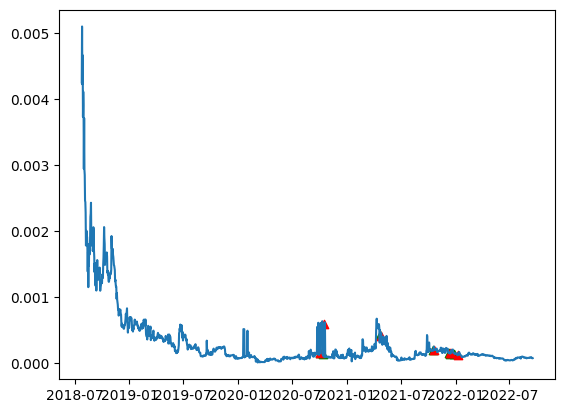

In [12]:
plt.plot(df.Close)
plt.scatter(df.loc[buydates].index, df.loc[buydates].Close, marker='^', c='g')
plt.scatter(df.loc[selldates].index, df.loc[selldates].Close, marker= '^', c='r')

In [13]:
buys

[0.00014937999410904012,
 0.00015811000412213616,
 0.0003007000029901974,
 0.00018332999854465016,
 0.00015325999542255885,
 0.00014550000691087916,
 0.0001503500014950987]

In [14]:
sells

[0.0005929999751970172,
 0.0005949999904260039,
 0.0003330000035930425,
 0.0001880000054370612,
 0.000155999994603917,
 0.0001539999939268455,
 0.00012199999764561653]

In [15]:
[(sell - buy)/buy for sell, buy in zip (sells, buys)]

[2.969741589119063,
 2.7632026748059584,
 0.10741603020169598,
 0.025473228219513953,
 0.01787811081295936,
 0.058419151974148646,
 -0.18856005033299816]

In [16]:
# Profit calculation
profits = pd.DataFrame([(sell - buy)/buy for sell, buy in zip (sells, buys)])

In [17]:
(profits + 1).cumprod() #accumulative profit

,0
0,3.969742
1,14.938942
2,16.543624
3,16.965044
4,17.268346
5,18.277149
6,14.830809


In [18]:
(df.Close.pct_change() + 1).cumprod() # take into consideration buy and order return

Date
2018-07-25         NaN
2018-07-26    1.199248
2018-07-27    0.993186
2018-07-28    1.096805
2018-07-29    0.877585
                ...   
2022-09-13    0.018562
2022-09-14    0.019267
2022-09-15    0.017387
2022-09-16    0.016917
2022-09-17    0.017387
Name: Close, Length: 1516, dtype: float64